In [ ]:
! pip install -q pytorch-lightning
! pip install -q bs4
! pip install -q transformers

     |████████████████████████████████| 708 kB 5.1 MB/s 
     |████████████████████████████████| 529 kB 64.3 MB/s 
     |████████████████████████████████| 5.9 MB 56.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220929150707 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.
     |████████████████████████████████| 4.9 MB 4.5 MB/s 
     |████████████████████████████████| 6.6 MB 43.4 MB/s 
     |████████████████████████████████| 163 kB 60.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import joblib




from sklearn import preprocessing


from tqdm import tqdm

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
## Preprocessing to convert text file to a format suitable for aspect recognition and analysis


In [ ]:
with open('/content/gdrive/MyDrive/laptop14/train.txt','r') as indata:
  sentanceNo = []
  wordList = []
  tag = []
  sentanceCount = 0
  for no,sentance in enumerate(indata):
    #if (no == 614 or no == 1226 or no == 1445): uncomment for procesing train 
      #continue 
    splits = sentance.split("####")
    iterate = splits[1]
    words = iterate.split(" ")
    for word in words:
      
      word = word.replace("\n","")
      wordSplit = word.split("=")
      
      if wordSplit[1] == 'ASPECT0':
        print("sentancec:"+str(no))
        
      if wordSplit[1] == '':
        print("sentancec:"+str(no))
        
      
      wordList.append(wordSplit[0])
      tag.append(wordSplit[1])
      sentanceNo.append(no)
      

    

FileNotFoundError: ignored

In [ ]:
len(test_data.groupby('sentence_id').count())

800

In [ ]:
train_data = pd.DataFrame({"sentence_id":sentanceNo,"words":wordList,"labels":tag})
#test_data = pd.DataFrame({"sentence_id":sentanceNo,"words":wordList,"labels":tag})

In [ ]:
#train_data.to_csv('/content/gdrive/MyDrive/laptop14/TrainLap.csv')
test_data.to_csv('/content/gdrive/MyDrive/laptop14/TestLap.csv')

NameError: ignored

In [ ]:
train_data = pd.read_csv('/content/gdrive/MyDrive/TrainLap.csv') #already converted format
test_data = pd.read_csv('/content/gdrive/MyDrive/TestLap.csv')

In [ ]:
train_data.labels.value_counts()

O        42077
T-POS     1222
T-NEG     1142
T-NEU      666
Name: labels, dtype: int64

In [ ]:
train_data["type"] = "train"
test_data["type"] = "test"

df3 = train_data.append(test_data, ignore_index=True)

In [ ]:
tag_enc = preprocessing.LabelEncoder()                #label encoding the labels
df3["labels"] = tag_enc.fit_transform(df3["labels"])



In [ ]:
train_data = df3[df3["type"] == "train"]
train_data.reset_index(drop=True, inplace=True)

test_data = df3[df3["type"] == "test"]
test_data.reset_index(drop=True, inplace=True)


In [ ]:
#getting the max size
print(train_data.groupby('sentence_id').count().max())

print(test_data.groupby('sentence_id').count().max())

Unnamed: 0    80
words         80
labels        80
type          80
dtype: int64
Unnamed: 0    67
words         67
labels        67
type          67
dtype: int64


In [ ]:
#Creating dataset and datamodule
class EntityDataset (Dataset):
    def __init__(self,df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.sentanceIds = train_data["sentence_id"].unique()
        
        self.max_len = max_len
        
    def __len__(self):
        
        return len(self.sentanceIds)
    
    def __getitem__(self, item_idx):
        sentanceID = self.sentanceIds[item_idx]
        
        text = self.df[self.df["sentence_id"] == sentanceID]["words"].tolist()
        #print(text)
        tags = self.df[self.df["sentence_id"] == sentanceID]["labels"].tolist()
        #print("lllllllllllllll")
        #print(tags)
        #print("lllllllllllllll")
        ids = []
        
        target_tag =[]
        
        for i, s in enumerate(text):
            inputs = self.tokenizer.encode(
                s,
                add_special_tokens=False
            )
            # abhishek: ab ##hi ##sh ##ek
            input_len = len(inputs)
            ids.extend(inputs)
            #print(ids)
            #print("pos:"+str(i))
            target_tag.extend([tags[i]] * input_len)
            #print(target_tag)
        ids = ids[:self.max_len - 2]
        
        target_tag = target_tag[:self.max_len - 2]

        ids = [101] + ids + [102]
        
        target_tag = [0] + target_tag + [0]

        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        padding_len = self.max_len - len(ids)

        ids = ids + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        
        target_tag = target_tag + ([0] * padding_len)

        
        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            
            "target_tag": torch.tensor(target_tag, dtype=torch.long),
        }
        #token_type_ids = inputs["token_type_ids"]
        
       

In [ ]:
# Initialize the parameters that will be use for training
N_EPOCHS = 8
BATCH_SIZE = 16
MAX_LEN = 1024
LR = 2e-05

In [ ]:
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "bert-base-cased" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        
        _,loss,f1_score,percision,recall = model(**data)
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss += loss.item()
        
    return final_loss / len(data_loader),f1_score,percision,recall


def eval_fn(data_loader, model, device):
    model.eval()
    final_loss = 0
    f1_score_total = 0
    percision_total = 0
    recall_total = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        _,loss,f1_score,percision,recall = model(**data)
        final_loss += loss.item()
        f1_score_total += f1_score
        percision_total += percision
        recall_total += recall
    return final_loss / len(data_loader),f1_score_total/len(data_loader),percision_total/len(data_loader),recall_total/len(data_loader)

In [ ]:
from torchmetrics import F1Score,Precision,Recall

device = torch.device("cuda")
f1 = F1Score(num_classes=4).to(device)

precision = Precision(average='macro', num_classes=4).to(device)
recall = Recall(average='macro', num_classes=4).to(device)
device = torch.device("cuda")



 

def loss_fn(output, target, mask, num_labels):
    
    
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    
    preds = output.argmax(2)
    preds = preds.view(-1)
    targ = target.view(-1)
    
    
    
    loss = lfn(active_logits, active_labels)
    if model.eval():
      f1_score = f1(preds, targ)
      percision_score = precision(preds, targ)
      recall_score = 0 #recall(preds, targ)
    else:
      f1_score,percision_score,recall_score = 0
    return loss,f1_score,percision_score,recall_score


class EntityModel(nn.Module):
    def __init__(self, num_tag):
        super(EntityModel, self).__init__()
        self.num_tag = num_tag
        
        self.bert = transformers.BertModel.from_pretrained(
            BERT_MODEL_NAME
        )
        self.bert_drop_1 = nn.Dropout(0.3)
        
        self.out_tag = nn.Linear(768, self.num_tag)
        
    
    def forward(
        self, 
        ids, 
        mask, f
        token_type_ids, 
        target_tag
    ):
        o1, _ = self.bert(
            ids, 
            attention_mask=mask, 
            token_type_ids=token_type_ids,
            return_dict=False
        )
        
        bo_tag = self.bert_drop_1(o1)
        
        

        tag = self.out_tag(bo_tag)
        

        loss_tag,f1_score,percision,recall = loss_fn(tag, target_tag, mask, self.num_tag)
        

        

        return tag, loss_tag, f1_score, percision, recall

In [ ]:
num_tag

4

In [ ]:
num_tag = len(list(tag_enc.classes_))

In [ ]:
train_dataset = EntityDataset(train_data, Bert_tokenizer,MAX_LEN)
val_dataset  = EntityDataset(test_data,Bert_tokenizer,MAX_LEN)
test_dataset  = EntityDataset(test_data,Bert_tokenizer,MAX_LEN)

train_data_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE)
test_data_loader = DataLoader(test_dataset,batch_size = 16)
val_data_loader = DataLoader(val_dataset,batch_size = 16)




In [ ]:
MODEL_PATH = "/content/gdrive/MyDrive/bestBert.bin"

In [ ]:

model = EntityModel(num_tag=num_tag)
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.0,
    },
]


num_train_steps = int(
    len(train_data.groupby('sentence_id').count()) / BATCH_SIZE * N_EPOCHS
)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_train_steps
)

best_loss = np.inf
train_loss_list = []
test_loss_list = []
for epoch in range(N_EPOCHS):
    train_loss, _, _, _ = train_fn(
        train_data_loader, 
        model, 
        optimizer, 
        device,
        scheduler
        
    )
    test_loss,f1_score,percision,recall = eval_fn(
        val_data_loader,
        model,
        device
    )
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    print(f"Epoch:{epoch} Train Loss = {train_loss} Valid Loss = {test_loss} [F1 Score: {f1_score}] [percision: {percision}] [recall: {recall}]")
    if test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = test_loss

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 172/172 [00:17<00:00,  9.59it/s]


Epoch:0 Train Loss = 0.19678269955871064 Valid Loss = 0.054279234189930005 [F1 Score: 0.9897945523262024] [percision: 0.837914228439331] [recall: 0.0]


100%|██████████| 172/172 [00:16<00:00, 10.19it/s]


Epoch:1 Train Loss = 0.07672221628579495 Valid Loss = 0.04585674420259027 [F1 Score: 0.9834089875221252] [percision: 0.8317174911499023] [recall: 0.0]


100%|██████████| 172/172 [00:16<00:00, 10.21it/s]


Epoch:2 Train Loss = 0.031917356394673295 Valid Loss = 0.04737073970893615 [F1 Score: 0.9781267642974854] [percision: 0.8276247382164001] [recall: 0.0]


100%|██████████| 172/172 [00:16<00:00, 10.25it/s]

Epoch:3 Train Loss = 0.014323276648081995 Valid Loss = 0.05433723993658976 [F1 Score: 0.9850618243217468] [percision: 0.8413801789283752] [recall: 0.0]


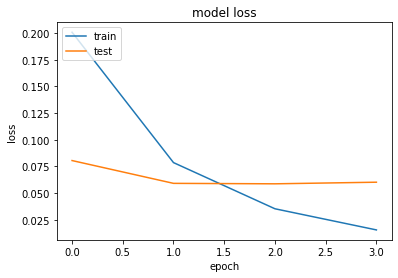

In [ ]:
# summarize history for loss
import matplotlib.pyplot as plt

plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()